In [ ]:
# Importar dependencias

# La librería JSON permite abrir y guardar archivos en formato JSON
import json
# Sklearn cuenta con una herramienta para dividir un dataset
# en un subconjunto de entrenamiento y un subconjunto de evaluación
# Ambos, son importantes para el trabajo con aprendizaje automatico
from sklearn.model_selection import train_test_split
# os es una librería propia de Python que permite precesar archivos
import os
# La librería TQDM permite integrar barras de progreso en estructuras repetitivas for
from tqdm.auto import tqdm
# La librería shutil tiene implementaciones optimizadas para trabajar con archivos
import shutil
# La librería random permite crear números aleatorios
import random
# La librería OpenCV contiene funciones y algoritmos para procesar imágenes y video
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import userdata

In [ ]:
# Definir las credentiales para acceder a Kaggle. Primero requerimos confirmar que
# el archivo aún no ha sido creado
KAGGLE_PATH = "/root/.kaggle"
if os.path.exists(KAGGLE_PATH):
  !rm -r "$KAGGLE_PATH"

!mkdir "$KAGGLE_PATH"
!touch "$KAGGLE_PATH/kaggle.json"

# Puedes crear tu propio token y username de la API de Kaggle en https://www.kaggle.com/
api_token = {"username":"USERNAME","key":userdata.get('kaggle')}

# Crear un archivo con las credenciales, de tal forma que kaggle pueda leerlas facilmente
with open(KAGGLE_PATH+'/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Cambiar los permisos de acceso del nuevo archivo con credenciales
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content

# Comprobar si el conjunto de datos ya se ha descargado
if os.path.exists('./covid_19'):
  !rm -rf covid_19
os.makedirs('covid_19')

# Descargar un dataset desde Kaggle
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p covid_19

/content
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 776M/778M [00:06<00:00, 85.6MB/s]
100% 778M/778M [00:06<00:00, 121MB/s] 


In [ ]:
# Descomprimir dataset
!unzip -qn '/content/covid_19/covid19-radiography-database.zip' -d /content/covid_19
!rm /content/covid_19/covid19-radiography-database.zip

In [ ]:
xlsx_files= {}
directory = '/content/covid_19/COVID-19_Radiography_Dataset'
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):
        filepath = os.path.join(directory, filename)
        df = pd.read_excel(filepath)
        xlsx_files[filename] = df

print("Loaded Excel files:")
for filename in xlsx_files:
    print(filename)
    display(xlsx_files[filename].head())

Loaded Excel files:
Lung_Opacity.metadata.xlsx


,FILE NAME,FORMAT,SIZE,URL
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


Normal.metadata.xlsx


,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


Viral Pneumonia.metadata.xlsx


,FILE NAME,FORMAT,SIZE,URL
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
2,Viral Pneumonia-3,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
3,Viral Pneumonia-4,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
4,Viral Pneumonia-5,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


COVID.metadata.xlsx


,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [ ]:
image_metadata = {}
base_dir = '/content/covid_19/COVID-19_Radiography_Dataset'

for category_dir in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category_dir)
    if os.path.isdir(category_path):
        # Find the corresponding metadata file
        metadata_file = None
        for filename in os.listdir(category_path):
            if filename.endswith('.metadata.xlsx'):
                metadata_file = os.path.join(category_path, filename)
                break

        metadata_df = None
        if metadata_file and os.path.exists(metadata_file):
            metadata_df = pd.read_excel(metadata_file)

        image_dir = os.path.join(category_path, 'images')
        if os.path.exists(image_dir):
            for image_filename in tqdm(os.listdir(image_dir), desc=f"Processing {category_dir}"):
                image_path = os.path.join(image_dir, image_filename)
                if os.path.isfile(image_path):
                    try:
                        # Get image size
                        image_size = os.path.getsize(image_path) # in bytes

                        # Get image dimensions using OpenCV
                        img = cv2.imread(image_path)
                        if img is not None:
                            height, width, _ = img.shape
                            image_dimensions = f"{width}x{height}"
                        else:
                            height, width = None, None
                            image_dimensions = None

                        # Get image format
                        image_format = os.path.splitext(image_filename)[1]

                        # Get file name without extension
                        file_name_without_extension = os.path.splitext(image_filename)[0]

                        # Get other metadata from the excel file if available
                        other_metadata = {}
                        if metadata_df is not None:
                            # Assuming 'FILE NAME' column in excel matches the image file name without extension
                            metadata_row = metadata_df[metadata_df['FILE NAME'] == file_name_without_extension]
                            if not metadata_row.empty:
                                other_metadata = metadata_row.iloc[0].to_dict()
                                # Remove 'FILE NAME', 'FORMAT', 'SIZE' and 'URL' as we are extracting them
                                other_metadata.pop('FILE NAME', None)
                                other_metadata.pop('FORMAT', None)
                                other_metadata.pop('SIZE', None)
                                other_metadata.pop('URL', None)


                        image_metadata[image_filename] = {
                            'file_path': image_path,
                            'size_bytes': image_size,
                            'dimensions': image_dimensions,
                            'width': width,
                            'height': height,
                            'file_name': image_filename,
                            'category': category_dir,
                            'format': image_format,
                            'other_metadata': other_metadata
                        }
                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")

# You can now access the image_metadata dictionary
# For example, to see the metadata for a single image:
# print(image_metadata['/content/covid_19/COVID-19_Radiography_Dataset/COVID/images/COVID-1.png'])

# To see the total number of images processed:
print(f"\nTotal images processed: {len(image_metadata)}")

# Display a sample of the metadata dictionary
sample_keys = list(image_metadata.keys())[:5] # Get first 5 keys
print("\nSample image metadata:")
for key in sample_keys:
    print(f"{key}: {image_metadata[key]}")

Processing COVID:   0%|          | 0/3616 [00:00<?, ?it/s]

Processing Normal:   0%|          | 0/10192 [00:00<?, ?it/s]

Processing Lung_Opacity:   0%|          | 0/6012 [00:00<?, ?it/s]

Processing Viral Pneumonia:   0%|          | 0/1345 [00:00<?, ?it/s]


Total images processed: 21165

Sample image metadata:
COVID-2680.png: {'file_path': '/content/covid_19/COVID-19_Radiography_Dataset/COVID/images/COVID-2680.png', 'size_bytes': 33342, 'dimensions': '299x299', 'width': 299, 'height': 299, 'file_name': 'COVID-2680.png', 'category': 'COVID', 'format': '.png', 'other_metadata': {}}
COVID-1746.png: {'file_path': '/content/covid_19/COVID-19_Radiography_Dataset/COVID/images/COVID-1746.png', 'size_bytes': 33759, 'dimensions': '299x299', 'width': 299, 'height': 299, 'file_name': 'COVID-1746.png', 'category': 'COVID', 'format': '.png', 'other_metadata': {}}
COVID-2121.png: {'file_path': '/content/covid_19/COVID-19_Radiography_Dataset/COVID/images/COVID-2121.png', 'size_bytes': 30653, 'dimensions': '299x299', 'width': 299, 'height': 299, 'file_name': 'COVID-2121.png', 'category': 'COVID', 'format': '.png', 'other_metadata': {}}
COVID-45.png: {'file_path': '/content/covid_19/COVID-19_Radiography_Dataset/COVID/images/COVID-45.png', 'size_bytes': 29

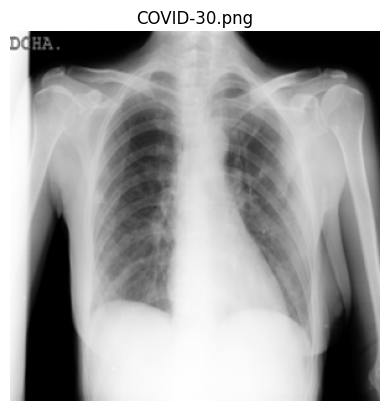

In [ ]:
def display_image_by_filename(filename, image_metadata):
    """
    Displays an image given its filename.

    Args:
        filename (str): The filename of the image (e.g., 'COVID-370.png').
        image_metadata (dict): The dictionary containing image metadata.
    """
    found_image_path = None
    for image_path, metadata in image_metadata.items():
        if metadata['file_name'] == filename:
            found_image_path = metadata["file_path"]
            break

    if found_image_path:
        try:
            img = cv2.imread(found_image_path)
            if img is not None:
                # Convert BGR to RGB for displaying with Matplotlib
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title(filename)
                plt.axis('off') # Hide axes
                plt.show()
            else:
                print(f"Could not read image file: {found_image_path}")
        except Exception as e:
            print(f"Error displaying image {filename}: {e}")
    else:
        print(f"Image with filename '{filename}' not found in metadata.")p

# Example usage:
display_image_by_filename('COVID-30.png', image_metadata)